# RAG using LlamaIndex

You have learnt about RAG in the previous sessions. Now let us implement a question answering assistant using LlamaIndex and OpenAI GPT models. This assistant will answer questions related to a specific set of documents and provide the location of its sources.
Before starting, let's revise a few topics.

## Part 0 - Quick Recap

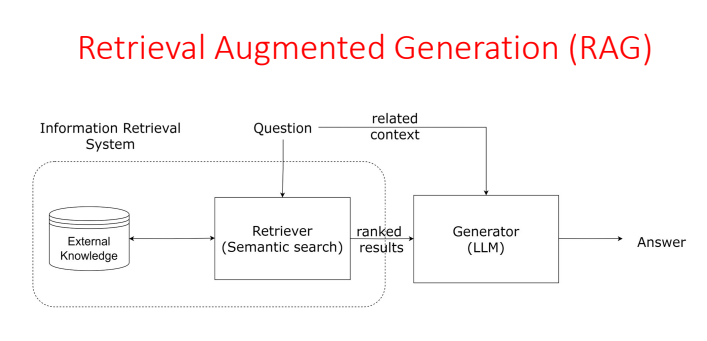

### RAG
**Retrieval-Augmented Generation** (RAG) is a method that improves the responses of a language model by using information from a knowledge base. It's like giving the model a library of information to reference when it's generating a response. This makes the model's responses more accurate and relevant.

RAG combines two types of models:
- ***retrieval models***, which pull data from a knowledge base, and
- ***generative models*** , which create the responses.

This combination makes RAG more powerful than a model that only generates responses. It can answer difficult questions and provide more informative responses.

### LlamaIndex
**LlamaIndex** is a framework for building context-augmented LLM applications. Context augmentation refers to any use case that applies LLMs on top of your private or domain-specific data.

Some popular use cases include the following:
* Question-Answering Chatbots (commonly referred to as RAG, or "Retrieval-Augmented Generation")
* Document Understanding and Extraction
* Autonomous Agents that can perform research and take actions

LlamaIndex provides the tools to build any of these above use cases from prototype to production. The tools allow you to ingest and process this data and implement complex queries. It combines data access with LLM prompting.

To install the library:

`pip install llama-index`

## Part 1 - Overall RAG Application Specifications

***Problem Statement*** - We are provided with Uber's 2021 financial statement. Our goal here is to build a simple RAG application on the annual financial statement pdf document.

***Solution Strategy*** - Build a POC which should solve the following requirements:

- Users would get responses from the financial statement.
- If they want to refer to the original page from which the bot is responding, the bot should provide a citation as well.

Goal - Solving the above two requirements well in the POC would ensure that the accuracy of the overall model is good and therefore further improvisations and customizations make sense.

***Data Used*** - Annual financial statement document of uber stored in a single folder

***Tools used*** - LlamaIndex (only for now) has been used due to its powerful query engine, fast data processing using data loaders and directory readers as well as easier and faster implementation using fewer lines of code.

## Part 2 - Solution POC

In this section, we go ahead and actually build a POC of the solution that we proposed in the previous step.

### Step 1: Import the necessary libraries

While installing LlamaIndex, you can specify the version to install. We are installing version `v0.10.34`, which was the latest release version at the time of writing this notebook.

In [1]:
# %pip install llama-index==0.10.34
!pip install -U -qq openai llama-index llama-index-core llama-index-readers-file llama-index-llms-openai llama-index-embeddings-openai

In [2]:
# ## Document loaders for SimpleDirectoryReader
# %pip install docx2txt
# %pip install pypdf
# ## Install openai
# %pip install openai

In [3]:
# NOTE: This is ONLY necessary in jupyter notebook.
# Details: Jupyter runs an event-loop behind the scenes.
#          This results in nested event-loops when we start an event-loop to make async queries.
#          This is normally not allowed, we use nest_asyncio to allow it for convenience.
import nest_asyncio
nest_asyncio.apply()

In [4]:
# Llama index already has its bundle which comes with OpenAI package included and will work even if you do not import openai separately.
from llama_index.llms.openai import OpenAI
from llama_index.core.llms import ChatMessage
import os
import openai

### Step 2 : Mount your Google Drive and Set the API key

In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Set the API key

# If you have saved the API key in Google Drive
# filepath = "/content/drive/MyDrive/GenAI Revamp - 2024/"
# with open(filepath + "OPENAI_API_Key.txt", "r") as f:
#   openai.api_key = ' '.join(f.readlines())

# If you have saved the API key in Colab environment
from google.colab import userdata
openai.api_key = userdata.get('OPENAI_API_KEY')

In [5]:
folder_path=r'D:\GenAI\Keys\\'
with open(folder_path + "OpenAI_API_Key.txt", "r") as f:
    openai.api_key = ' '.join(f.readlines())


Let's check if the OpenAI API is working correctly

In [6]:
messages = [
    ChatMessage(role="system", content="You are an AI assistant to the user."),
    ChatMessage(role="user", content="What is the revenue of Uber in 2021?")
]
resp = OpenAI().chat(messages)
print(resp)

assistant: Uber's revenue in 2021 was $16.5 billion.


### Step 3 - Data Loading (Ingestion)

Before your LLM can act on your data, you need to process and load it. The way LlamaIndex does this is via data connectors, also called `Reader`. Data connectors ingest data from different data sources and format the data into `Document` objects. A `Document` is a collection of data (currently text, and in future, images and audio) and metadata about that data.


***3 ways to do this***

- If you have a single file containing all the required data, use a data loader or reader from [LLamahub](https://llamahub.ai/)
    https://llamahub.ai/l/readers/llama-index-readers-file

- If you have multiple files, the simplest way is to use *SimpleDirectoryReader*. It is built in to LlamaIndex and can read a variety of formats including Markdown, PDFs, Word documents, PowerPoint decks, images, audio and video. Just ensure that for reading each file type the necessary dependency libraries are already installed.
    https://docs.llamaindex.ai/en/stable/module_guides/loading/simpledirectoryreader.html

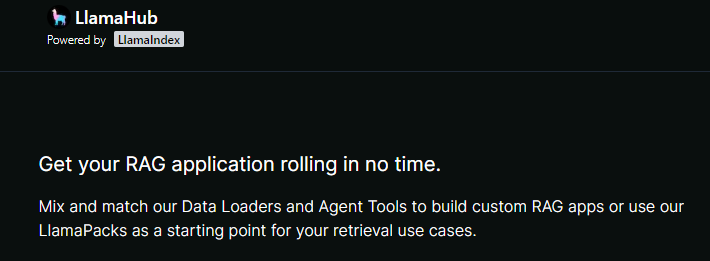

- Llamaparse: A very recent method for parsing documents. This is claimed as the first **GenAI native document parsing platform** .

    - [LinkedIN Post](https://www.linkedin.com/posts/llamaindex_were-excited-to-officially-launch-llamaparse-activity-7173714437860782080-Zqmf)

    - [Blog Post](https://www.llamaindex.ai/blog/launching-the-first-genai-native-document-parsing-platform)

_Recommendation_ - No matter how powerful the given data loader is, ensure that your file is properly formatted, and the loader is able to read the file clearly, or the query engine might fail.

##### Using SimpleDirectoryReader
Here are some attributes that can be passed to the `SimpleDirectoryReader`:

* `input_dir`: The directory from which you have to load files.
* `recursive`: If set to *True*, it will read files from subdirectories too.
* `input_files`: A list of specific file paths to load.
* `exclude`: A list of file paths to exclude.

Refer to [this documentation](https://docs.llamaindex.ai/en/stable/module_guides/loading/simpledirectoryreader/) for more info on SimpleDirectoryReader


In [7]:
from llama_index.core import SimpleDirectoryReader

# Let us take input from a directory
reader = SimpleDirectoryReader(input_dir="/content/drive/MyDrive/Semantic_Spotter_Project_Resources")

In [12]:
from llama_index.core import SimpleDirectoryReader

# Let us take input from a directory
reader = SimpleDirectoryReader(input_dir=r"D:\GenAI\uber")

In [13]:
# Use the load_data() method to read the files from the directory
documents = reader.load_data()
# number of files
print(f"Loaded {len(documents)} docs")

Loaded 307 docs


In [14]:
type(documents)

list

Note: <br>

317 documents is a lot more than the actual number of files you can see if you open this directory. This is because the reader is considering each page as one document. This is better because more information about less text can be stored in the metadata. See an example where we read the first document from the list.

In [15]:
documents[0]

Document(id_='f34acc3b-2e96-46f2-bb58-86a434ac52c5', embedding=None, metadata={'page_label': '1', 'file_name': 'uber_2021.pdf', 'file_path': 'D:\\GenAI\\uber\\uber_2021.pdf', 'file_type': 'application/pdf', 'file_size': 1880483, 'creation_date': '2024-09-05', 'last_modified_date': '2024-08-25'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text='UNITED STATESSECURITIES AND EXCHANGE COMMISSION\nWashington, D.C. 20549\n____________________________________________ \nFORM\n 10-K____________________________________________ \n(Mark One)\n☒\n ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934For the fiscal year ended\n December 31, 2021OR\n☐\n TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934

In [16]:
# Another method to load the documents
# Instead of SimpleDirectoryReader, we are using another loader for PDFs called PDFReader
from pathlib import Path
from llama_index.readers.file import PDFReader


loader = PDFReader()
documents2 = loader.load_data(file = r'D:\GenAI\lamaindex\uber_2021.pdf')

In [17]:
print('Loaded docs:', len(documents2))
type(documents2)

Loaded docs: 307


list

In [18]:
documents2[0]

Document(id_='1d021b7b-5bdc-48f5-9c34-06445af708f8', embedding=None, metadata={'page_label': '1', 'file_name': 'uber_2021.pdf'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='UNITED STATESSECURITIES AND EXCHANGE COMMISSION\nWashington, D.C. 20549\n____________________________________________ \nFORM\n 10-K____________________________________________ \n(Mark One)\n☒\n ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934For the fiscal year ended\n December 31, 2021OR\n☐\n TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934For the transition period from_____ to _____            \nCommission File Number: 001-38902\n____________________________________________ \nUBER TECHNOLOGIES, INC.\n(Exact name of registrant as specif\nied in its charter)____________________________________________ \nDelaware\n45-2647441 (State or other jurisdiction of inco\nrporation or organization)(I.R.S. Emp

As you can see, when we load only a single PDF, the number of documents change. There are 307 pages in the file `uber_2021.pdf`.

### Core Components Of LlamaIndex

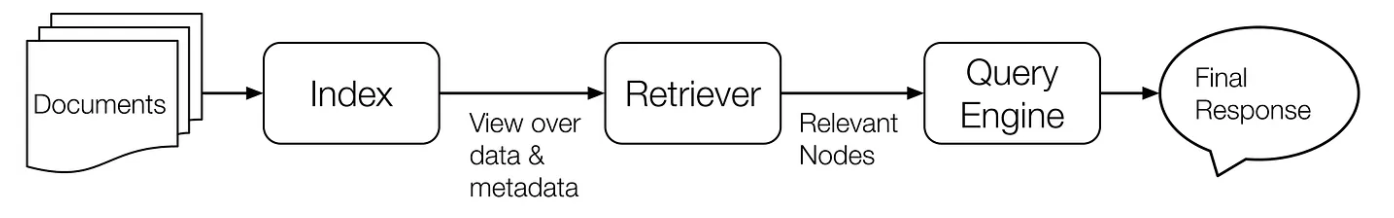

You can understand the core components of Llamaindex with this analogy:
1. Documents: These are the "books" in your library.
2. Index: It's the "library" of your data - Stores your data.
3. Retriever: It's the "librarian" that finds relevant data - Finds data.
4. Response Synthesizer: It's the "storyteller" that creates a response - Makes responses.
5. QueryEngine: It's the "director" that makes everything work together - Coordinates everything.

#### Documents and Nodes
Documents in LlamaIndex may be different from your traditional perception of documents. <br>
Document and Node objects are core abstractions within LlamaIndex.

A **Document** is a generic container around any data source - for instance, a PDF, an API output, or retrieved data from a database. They can be constructed manually, or created automatically via data loaders. By default, a Document stores text along with some other attributes. Some of these are

`metadata` - a dictionary of annotations that can be appended to the text (basically, additional info about the document) <br>
`relationships` - a dictionary containing relationships to other Documents/Nodes.

<br>

A **Node** represents a "chunk" of a source Document, whether that is a text chunk, an image, or other. Similar to Documents, they contain metadata and relationship information with other nodes.

Nodes are a first-class citizen in LlamaIndex. You can choose to define Nodes and all its attributes directly. You may also choose to "parse" source Documents into Nodes through our `NodeParser` classes. By default every Node derived from a Document will inherit the same metadata from that Document (e.g. a "file_name" filed in the Document is propagated to every Node).

Both Documents and Nodes have unique identifies called `ID`. These can be set automatically or manually. `ID` is generally used to identify, update, and define relationships between documents (or nodes).

For additional reading: [LlamaIndex Documentation](https://docs.llamaindex.ai/en/stable/module_guides/loading/documents_and_nodes/#documents-nodes)


In [20]:
# Sample usage of Documents and Nodes

# Documents

from llama_index.core import Document, VectorStoreIndex

# text_list = [text1, text2, ...]
# documents = [Document(text=t) for t in text_list]

text = 'text'
docs = [Document(text=text)]

# build index
index = VectorStoreIndex.from_documents(docs)
print(index)

# Nodes

from llama_index.core.node_parser import SentenceSplitter

# load documents
# documents = documents

# parse nodes
parser = SentenceSplitter()
nodes = parser.get_nodes_from_documents(docs)

# build index
index = VectorStoreIndex(nodes)

print(nodes[0])
print(index)

Node ID: d81c5f64-6695-4e3a-97d5-648100a9bd30
Text: text


**Node Parser**: [Node parsers](https://docs.llamaindex.ai/en/stable/module_guides/loading/node_parsers/modules/#node-parser-modules) chunk a document into nodes. There are several file-based node parsers, that will create nodes based on the type of content that is being parsed (JSON, Markdown, etc.)

However, for better manageability and efficiency in parsing, you can first split the text. This is done using splitters.<br>
**Splitters** are responsible for breaking down the text into smaller, manageable pieces, often called chunks or nodes. These chunks can be based on various criteria such as sentence boundaries, semantic similarity, or other custom rules.

#### Index
An `Index` is a data structure that allows us to quickly retrieve relevant context for a user query. For LlamaIndex, it's the core foundation for RAG use-cases.

At a high-level, `Indexes` are built from Documents. They are used to build Query Engines and Chat Engines which enables question & answer and chat over your data.

Under the hood, Indexes store data in Node objects, and expose a Retriever interface that supports additional configuration and automation.

The most common index by far is the VectorStoreIndex.

##### Using VectorStoreIndex#
Vector Stores are a key component of RAG and so you will end up using them in nearly every application you make using LlamaIndex, either directly or indirectly.

Vector stores accept a list of Node objects and build an index from it.
<br>

**Loading data into the index**

The simplest way to use a Vector Store is to load a set of documents and build an index from them using from_documents:

In [21]:
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
# Load documents and build index
index = VectorStoreIndex.from_documents(documents)

Tip:

If you are using `from_documents` on the command line, it can be convenient to pass `show_progress=True` to display a progress bar during index construction.

When you use `from_documents`, your Documents are split into chunks and parsed into Node objects, lightweight abstractions over text strings that keep track of metadata and relationships.

**Creating and managing nodes directly**

If you want total control over your index you can create and define nodes manually and pass them directly to the index constructor:

In [22]:
from llama_index.core.schema import TextNode

node1 = TextNode(text="<text_chunk>", id_="<node_id>")
node2 = TextNode(text="<text_chunk>", id_="<node_id>")
nodes_0 = [node1, node2]
index0 = VectorStoreIndex(nodes_0)
print(index0)

#### Retrievers and ResponseSynthesizers
**Retrievers** are responsible for fetching the most relevant context given a user query (or chat message).

It can be built on top of indexes, but can also be defined independently. It is used as a key building block in query engines (and Chat Engines) for retrieving relevant context.
```
retriever = index.as_retriever()
nodes = retriever.retrieve("What was Uber's revenue in 2021?")
```

**ResponseSynthesizers** generate a response from an LLM, using a user query and a given set of text chunks. The output of a response synthesizer is a Response object.

The method for doing this can take many forms, from as simple as iterating over text chunks, to as complex as building a tree.

#### Query Engines
Query engine is a generic interface that allows you to ask question over your data.

A query engine takes in a natural language query, and returns a rich response. It is most often (but not always) built on one or many indexes via retrievers. You can compose multiple query engines to achieve more advanced capability.


``` Python
query_engine = index.as_query_engine()
response = query_engine.query("What was Uber's revenue in 2021?")
```

To stream response: <br>
LlamaIndex supports streaming the response as it's being generated. This allows you to start printing or processing the beginning of the response before the full response is finished, so you can see the words as they are being generated.

In [23]:
# Streaming
query_engine = index.as_query_engine(streaming=True)
streaming_response = query_engine.query("What information do you have about the mobility service of uber?")
streaming_response.print_response_stream()

Uber's mobility service connects consumers with Mobility Drivers who provide rides using various types of vehicles such as cars, auto rickshaws, motorbikes, minibuses, or taxis. The mobility service also includes activities related to financial partnerships offerings. Uber calculates its ridesharing category position based on data within a given region, estimating total ridesharing Gross Bookings by utilizing internal and external data sources. The company believes it holds a leading ridesharing category position in every major region where it operates. Additionally, Uber participates in certain regions through minority-owned affiliates and has made strategic acquisitions to strengthen its position in the mobility service market.

### Step 4 - Building the query engine
A Query Engine wraps a Retriever and a ResponseSynthesizer into a pipeline. It uses the query string to fetch nodes and then sends them to the Large Language Model (LLM) to generate a response.

In [24]:
from llama_index.core.node_parser import SimpleNodeParser
from llama_index.core import VectorStoreIndex
from IPython.display import display, HTML

# create parser and parse document into nodes
parser = SimpleNodeParser.from_defaults()
nodes = parser.get_nodes_from_documents(documents)

# # build index
index = VectorStoreIndex(nodes)

# Construct Query Engine
query_engine = index.as_query_engine()

In [25]:
type(index)

llama_index.core.indices.vector_store.base.VectorStoreIndex

You can also store this VectorStoreIndex. You can read more here - https://docs.llamaindex.ai/en/stable/understanding/storing/storing.html

In [26]:
response = query_engine.query("What is the revenue of uber in 2021?")

In [27]:
# Output from a query engine is a response object
type(response)

llama_index.core.base.response.schema.Response

In [28]:
## What are the options available with the response object
dir(response)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'get_formatted_sources',
 'metadata',
 'response',
 'source_nodes']

In [29]:
# Fetching the response value which contains the actual response inside the response object
response.response

'The revenue of Uber in 2021 was $17,455 million.'

In [30]:
# You can also see the metadeta of the response
response.metadata

{'e28cde2d-0622-45e7-ae53-3d994ab95f02': {'page_label': '57',
  'file_name': 'uber_2021.pdf',
  'file_path': 'D:\\GenAI\\uber\\uber_2021.pdf',
  'file_type': 'application/pdf',
  'file_size': 1880483,
  'creation_date': '2024-09-05',
  'last_modified_date': '2024-08-25'},
 'cf85ca61-d9d4-44a9-8dba-978d614a7e07': {'page_label': '129',
  'file_name': 'uber_2021.pdf',
  'file_path': 'D:\\GenAI\\uber\\uber_2021.pdf',
  'file_type': 'application/pdf',
  'file_size': 1880483,
  'creation_date': '2024-09-05',
  'last_modified_date': '2024-08-25'}}

In [31]:
# These are the nodes used as source
response.source_nodes

[NodeWithScore(node=TextNode(id_='e28cde2d-0622-45e7-ae53-3d994ab95f02', embedding=None, metadata={'page_label': '57', 'file_name': 'uber_2021.pdf', 'file_path': 'D:\\GenAI\\uber\\uber_2021.pdf', 'file_type': 'application/pdf', 'file_size': 1880483, 'creation_date': '2024-09-05', 'last_modified_date': '2024-08-25'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='30d2b132-406d-427a-951b-dd3912332d5b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'page_label': '57', 'file_name': 'uber_2021.pdf', 'file_path': 'D:\\GenAI\\uber\\uber_2021.pdf', 'file_type': 'application/pdf', 'file_size': 1880483, 'creation_date': '2024-09-05', 'last_modified_date': '2024-08-25'}, hash='40b7db0a2a722ebc1f4c88f33dd6b01f577e6b

In [32]:
#Extract the file name
response.source_nodes[0].node.metadata['file_name']

'uber_2021.pdf'

In [33]:
# We can even extract the file name and page number from where the response was taken
response.source_nodes[0].node.metadata['file_name'] + " page no " + response.source_nodes[0].node.metadata['page_label']

'uber_2021.pdf page no 57'

In [34]:
#Extract the score
response.source_nodes[0].score

0.8654146390476958

In [35]:
# Response node text
response.source_nodes[0].node.text

'The following table sets forth the components of our consolidated statements of operations for each of the periods presented as a percentage of revenue : Year Ended December 31,\n2020\n2021 Revenue\n100 %100 %Costs and expenses\nCost of revenue, exclusive of dep\nreciation and amortization shown separately below46 %54 %Operations and support\n16 %11 %Sales and marketing\n32 %27 %Research and development\n20 %12 %General and administrative\n24 %13 %Depreciation and amortization\n5 %5 %Total costs and expenses\n144 %122 %Loss from operations\n(44) %(22) %Interest expense\n(4) %(3) %Other income (expense), net\n(15) %19 %Loss before income taxes and loss from equity me\nthod investments(62) %(6) %Provision for (benefit fro\nm) income taxes(2) %(3) %Loss from equity method invest\nments— %— %Net loss including non-controlling interests\n(61) %(3) %Less: net loss attributab\nle to non-controlling interests, net of tax— %— %Net loss attributable to Uber Technologies, Inc.\n(61) %(3) % Total

### Step 5 - Creating a response Pipeline

User receives the response and the document that they can refer to

In [36]:
## Query response function
def query_response(user_input):
  response = query_engine.query(user_input)
  file_name = response.source_nodes[0].node.metadata['file_name'] + " page nos " + response.source_nodes[0].node.metadata['page_label'] + "," + response.source_nodes[1].node.metadata['page_label']
  final_response = response.response + '\n Check further at ' + file_name
  return final_response

In [37]:
def initialize_conv():
  print('Feel free to ask Questions regarding uber 2021 financial report. Press exit once you are done')
  while True:
    user_input = input()
    # Type 'exit' to exit conversation
    if user_input.lower() == 'exit':
      print('Exiting the program... bye')
      break
    else:
      response = query_response(user_input)
      display(HTML(f'<p style="font-size:20px">{response}</p>'))

In [38]:
initialize_conv()

Feel free to ask Questions regarding uber 2021 financial report. Press exit once you are done
what was uber revenue in 2021?


exit
Exiting the program... bye


### Step 6 - Build a Testing Pipeline

Here we feed a series of questions to the Q/A bot and store the responses along with the feedback on whether it's accurate or not from the user

In [39]:
questions = ['What was uber revenue in 2021?', "Which services gave uber the most revenue",
             'What was uber loss in 2021?']

In [40]:
def testing_pipeline(questions):
  test_feedback  = []
  for i in questions:
    print(i)
    print(query_response(i))
    print('\n Please provide your feedback on the response provided by the bot')
    user_input = input()
    page = query_response(i).split()[-1]
    test_feedback.append((i,query_response(i),page,user_input))

  feedback_df = pd.DataFrame(test_feedback, columns =['Question', 'Response', 'Page','Good or Bad'])
  return feedback_df

In [41]:
import pandas as pd

In [42]:
testing_pipeline(questions)

What was uber revenue in 2021?
Uber's revenue in 2021 was $17,455 million.
 Check further at uber_2021.pdf page nos 57,129

 Please provide your feedback on the response provided by the bot
good
Which services gave uber the most revenue
Mobility revenue provided Uber with the most revenue.
 Check further at uber_2021.pdf page nos 98,129

 Please provide your feedback on the response provided by the bot
good
What was uber loss in 2021?
Uber's loss in 2021 was $485 million.
 Check further at uber_2021.pdf page nos 78,77

 Please provide your feedback on the response provided by the bot
good


,Question,Response,Page,Good or Bad
0,What was uber revenue in 2021?,"Uber's revenue in 2021 was $17,455 million.\n ...","57,129",good
1,Which services gave uber the most revenue,Mobility services provided the most revenue fo...,"98,129",good
2,What was uber loss in 2021?,Uber's loss in 2021 was $570 million.\n Check ...,"78,77",good


## Part 3 - Next Steps


### 3.1 - Building a custom prompt template

We saw that in one of the questions the model was not able to answer properly, or rather give a very detailed answer. Let's see how we can use a custom prompt template to mitigate the issue

**This is similar to the generation layer that we did in HelpMate AI**

In [43]:
response = query_engine.query("Which services gave uber the most revenue?")

In [44]:
response.response

'Mobility revenue gave Uber the most revenue.'

In [45]:
response.source_nodes[0]

NodeWithScore(node=TextNode(id_='1005b3d2-c718-4bdd-a7f0-ebd4d72f7eec', embedding=None, metadata={'page_label': '98', 'file_name': 'uber_2021.pdf', 'file_path': 'D:\\GenAI\\uber\\uber_2021.pdf', 'file_type': 'application/pdf', 'file_size': 1880483, 'creation_date': '2024-09-05', 'last_modified_date': '2024-08-25'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='5621431f-8ff5-42e8-95d8-8437fcff3b00', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'page_label': '98', 'file_name': 'uber_2021.pdf', 'file_path': 'D:\\GenAI\\uber\\uber_2021.pdf', 'file_type': 'application/pdf', 'file_size': 1880483, 'creation_date': '2024-09-05', 'last_modified_date': '2024-08-25'}, hash='ea30a9408544431e934761d231ba28834880bdb

In [46]:
response.source_nodes[1].node.text

"Year Ended December 31,2019\n2020 2021 United States\n$ 7,968 $ 6,082 $ 9,058 All other countries\n5,032 5,057 8,397 Total Revenue\n$ 13,000 $ 11,139 $ 17,455 As of December 31,\n2020\n2021 United States\n$ 2,940 $ 2,991 All other countries\n252 250 Total long-lived assets, net\n$ 3,192 $ 3,241 Revenue grouped by offerings is inc\nluded in Note 2 – Revenue.Note 15 – Commitments and Contingencies\nContingencies\nFrom time to time, we are a party to various claims, non-income tax audits and litigation in the normal course of b\nusiness. As of December 31, 2020 and 2021,we\n had  recorded  aggregate  liabilities  of  $1.8  billion  and  $2.2  billion,  respectively,  of  which  $1.3  billion  and  $1.3  billion  relate  to  non-income  tax  matters,respectively,\n in  accrued  and  other  current  liabilities  on  the  consolidated  balance  sheets  for  all  of  our  legal,  regulatory  and  non-income  tax  matters  that  wereprobable and reasonably est\nimable.We\n are  currently  par

In [47]:
retrieved = response.source_nodes[0].node.text + response.source_nodes[1].node.text

In [48]:
messages = [
    {"role":"system", "content":"You are an AI assistant to user."},
    {"role":"user", "content":f"""What services gave uber the most revenue? Check in '{retrieved}' """},
          ]

In [49]:
response2 = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages)
response2.choices[0].message.content

"Based on the information provided in the excerpt from Uber's financial report, the services that generated the most revenue for Uber in the years ended December 31, 2019, 2020, and 2021 are as follows:\n\n1. Mobility Revenue:\n   - 2019: $10,707 million\n   - 2020: $6,089 million\n   - 2021: $6,953 million\n\n2. Delivery Revenue:\n   - 2019: $1,401 million\n   - 2020: $3,904 million\n   - 2021: $8,362 million\n\n3. Freight Revenue:\n   - 2019: $731 million\n   - 2020: $1,011 million\n   - 2021: $2,132 million\n\n4. All Other Revenue:\n   - 2019: $161 million\n   - 2020: $135 million\n   - 2021: $8 million\n\nFrom the data provided, it can be seen that in 2021, Delivery revenue generated the most revenue for Uber, followed by Mobility revenue and Freight revenue."

### 3.2 - Recommendations on how to further improve this
- Based on the testing pipeline's feedback develop a strategy on how to improve the POC further
  - This can be through building a better/cleaner dataset, or utilizing better data pre-processing techniques
- If the accuracy is good enough, think of implementing some more use cases and user stories. Maybe a set of users want to do XYZ, and that requirement needs to be implemented in the solution. Think of a proper tool that can enable you to do that.
- Few suggestions based on the common tools that we have in the pipeline
https://docs.llamaindex.ai/en/stable/optimizing/basic_strategies/basic_strategies.html

***Suggestion 1 - Using Customized Nodes and LLMs***

This can be used if your responses are not accurate or is not being summarized very well



In [50]:
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core.node_parser import SentenceSplitter
from llama_index.llms.openai import OpenAI
from llama_index.core import Settings

##Initialize the OpenAI model
Settings.llm = OpenAI(model="gpt-3.5-turbo", temperature=0, max_tokens=256)

##Initialize the embedding model
Settings.embed_model = OpenAIEmbedding()

## Initialize the node_parser with the custom node settings
Settings.node_parser = SentenceSplitter(chunk_size=512, chunk_overlap=20)

## Initialize the num_output and the context window
Settings.num_output = 512
Settings.context_window = 3900

# Create a VectorStoreIndex from a list of documents using the service context
index = VectorStoreIndex.from_documents(documents)

# Initialize a query engine for the index with a specified similarity top-k value
query_engine = index.as_query_engine(similarity_top_k=3)

In [51]:
#Query the engine with a specific question
response = query_engine.query("What is the revenue of uber in 2021? Give the answer in billions")

In [52]:
response.response

'$17.455 billion'

***Suggestion 2 - Evaluation of response*** (Optional)

https://docs.ragas.io/en/latest/howtos/integrations/llamaindex.html